In [1]:
import os
import sys
sys.path.insert(0, "../../")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.text.epu import EPU

from bokeh.layouts import Row, column, gridplot
from bokeh.models import (Title, Legend, ColumnDataSource, Select, HoverTool,
                          BoxZoomTool, ResetTool, DataTable, DateFormatter,
                          TableColumn)
from bokeh.models.layouts import TabPanel, Tabs
from bokeh.plotting import figure, output_file, show, output_notebook

output_file(filename=sys.path[0] + "docs/images/interactive/text/epu_pic_job.html")

In [2]:
parent_dirs = sys.path[0] + "data/text/"
country_dirs = [
    parent_dirs + country for country in os.listdir(parent_dirs)
    if country != ".DS_Store" and "marshall_islands" not in country
]
output_dir = sys.path[0] + "outputs/text/"

In [13]:
additional_terms = [
    "job",
    "labor",
    "jobs",
    'career',
    "vacancies",
    "vacancy",
    'employment',
    "salary",
    'unemployment',
    'full-time',
    'part-time',
    'contractual',
    'freelance',
    'remote work',
    'gig',
    'employed',
    'resume',
    'cv',
    'cover letter',
    'hiring',
    'recruitment',
    'unemployed',
    'underemployed',
    'self-employed',
    'jobless',
    'retired',
    'layoffs',
    'job application',
    "occupation",
    "soft skills"
    'hard skills',
    'labor force',
    'job market',
    'minimum wage'
    'disabled worker',
    'career advancement',
    'workplace culture',
    'retirement plans',
    'maternity leave',
    'paternity leave',
]

inflation_terms = [
    'inflation',
    'cpi',
    'price',
    'expense',
    'budget',
    'income',
    'demand',
    'cost',
    'supply',
    'goods',
    'food',
    "tabcco",
    'rent',
    'salary',
    "utilies",
    "fuel",
    'clothing',
    "rice",
    "noodle",
    "flour",
    "sugar",
    "salt",
    "consumer"
]

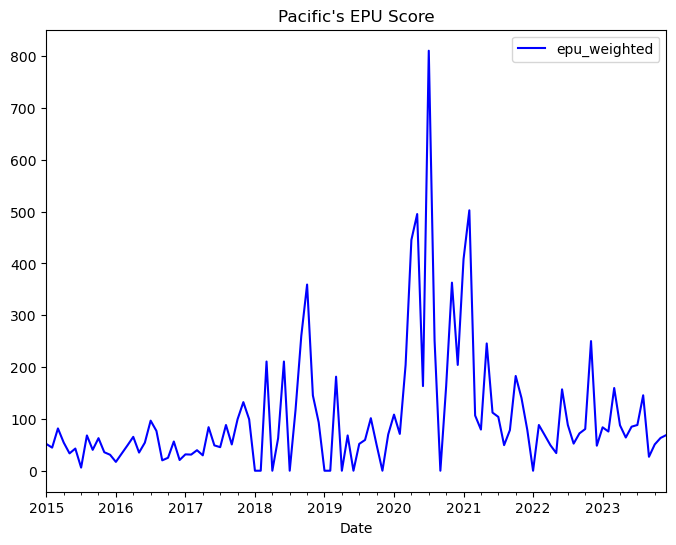

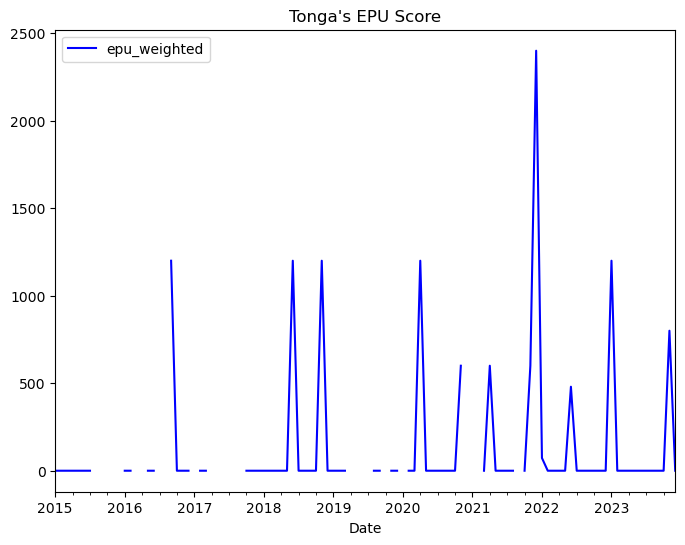

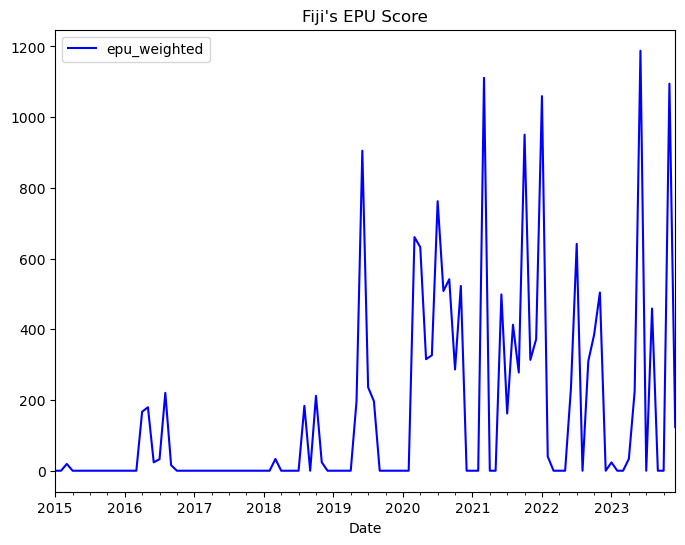

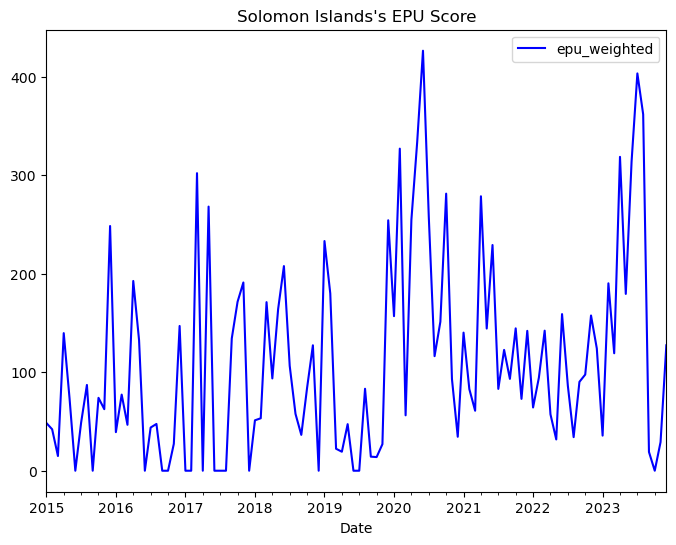

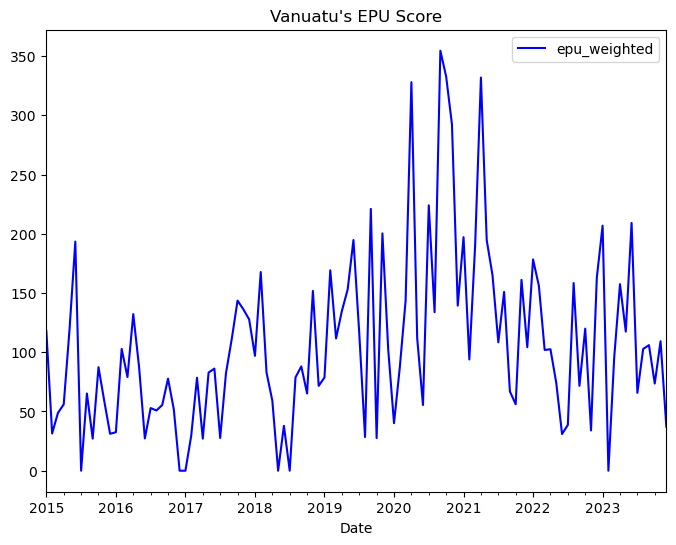

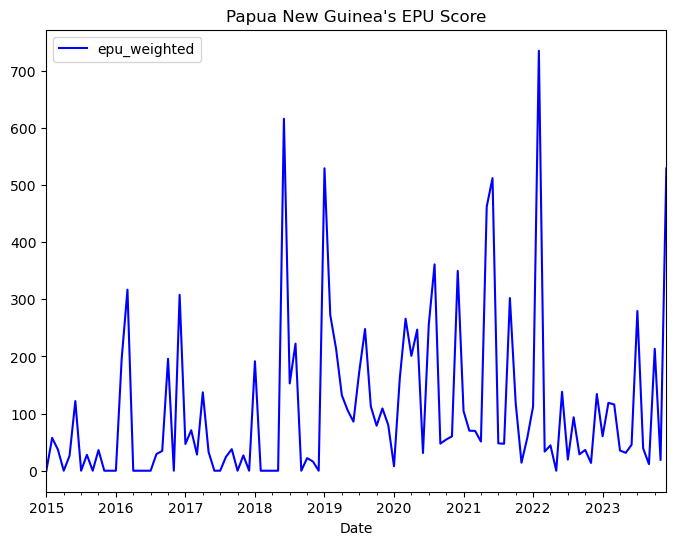

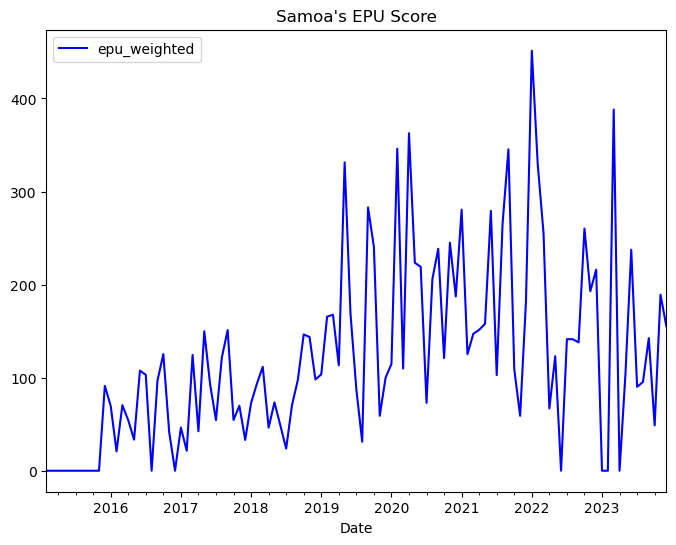

In [14]:
for country in country_dirs:
    country_name = country.split("/")[-1]
    news_dirs = [
        f"{country}/{file}" for file in os.listdir(country) if "news" in file
        and "ner" not in file
    ]
    
    ner_files = [f"{country}/{file}" for file in os.listdir(country) if "ner" in file]

    excl_urls = []
    for ner_file in ner_files:
        ner_df = pd.read_csv(ner_file)
        for url, ner in zip(ner_df["url"], ner_df["ner"]):
            if "risk" in str(ner).lower():
                excl_urls.append(url)
    
    e = EPU(news_dirs, cutoff="2020-12-31", non_epu_urls=excl_urls, additional_terms=inflation_terms)
    e.get_epu_category(subset_condition="date >= '2015-01-01' and date < '2024-01-01'")
    e.get_count_stats()
    e.calculate_epu_score()
    
    epu_stats = e.epu_stats
    fig, ax = plt.subplots(figsize=(8, 6))
    epu_stats.plot(x="date", y="epu_weighted", color="blue", ax=ax)
#     epu_stats.plot(x='date', y="epu_unweighted", color="lightgray", alpha=0.5, ax=ax)
    
    title = " ".join(n[0].upper() + n[1:] for n in country_name.split("_"))
    ax.set_title(f"{title}'s EPU Score")
    ax.set_xlabel("Date")
    
    saved_folder = output_dir + f"{country_name}/epu/"
    fig.savefig(saved_folder + f"{country_name}_epu_inflation.png", dpi=400)
    
    epu_stats.to_csv(saved_folder + f"{country_name}_epu_inflation.csv", encoding="utf-8")

In [9]:
countries = [
    "pacific",
    "papua_new_guinea", "solomon_islands", "fiji", "samoa",
    "vanuatu"
]

tabs = []

for country in countries:
    epu_file = sys.path[0] + f"outputs/text/{country}/epu/{country}_epu_job.csv"
    epu = pd.read_csv(epu_file).drop("Unnamed: 0", axis=1)
    epu["date"] = pd.to_datetime(epu["date"], format="mixed")
    epu["epu_weighted_ma3"] = epu["epu_weighted"].rolling(window=3).mean()

    source = ColumnDataSource(epu)

    hover = HoverTool(tooltips=[('Date', '@date{%Y-%m}'),
                                ('EPU weighted', '@epu_weighted'),
                                ('EPU (MA 3)', '@epu_weighted_ma3')],
                      formatters={'@date': 'datetime'})

    p = figure(height=400,
               width=700,
               x_axis_type="datetime",
               tools=[hover, BoxZoomTool(), ResetTool()])

    p.line("date",
           "epu_weighted",
           source=source,
           name="epu_weighted",
           line_width=2,
           legend_label="EPU (weighted)")

    p.line("date",
           "epu_weighted_ma3",
           source=source,
           name="epu_unweighted",
           color='darkorange',
           line_width=1.5,
           legend_label="EPU (MA 3)")

    p.legend.location = "top_left"
    p.legend.click_policy = "mute"

    # Add a vertical
    p.vspan(x=pd.to_datetime("2021-01-01"),
            line_dash="dashed",
            line_color="green",
            name="cutoff")

    epu_dt = (epu.set_index("date").groupby(
        [pd.Grouper(freq="Y")])[["epu_weighted",
                                 "epu_unweighted"]].mean().reset_index())

    dt_source = ColumnDataSource(epu_dt)

    columns = [
        TableColumn(field="date", title="Date", formatter=DateFormatter()),
        TableColumn(field="epu_weighted", title="EPU Weighted (Avg.)"),
        TableColumn(field="epu_unweighted", title="EPU Unweighted (Avg.)"),
    ]
    dt = DataTable(source=dt_source, columns=columns, width=700, height=300)
    combined = column(p, dt)

    # Uppercase the first letter of the country name
    title = " ".join(w[0].upper() + w[1:] for w in country.split("_"))
    tab = TabPanel(child=combined, title=title)
    tabs.append(tab)

show(Tabs(tabs=tabs))